## Лабораторная работа №6
- Понижение размерности
- Отбор признаков
- Извлечение признаков

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:

import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

In [3]:
data_reg = pd.read_csv("result_mumbai.csv")
data_class = pd.read_csv("result_neo.csv")

In [4]:
data_reg.head()

,price,area,latitude,longitude,bedrooms,bathrooms,balcony,ready_to_move,new_housing,parking,lift,flat_or_individual,furnished_status_Semi-Furnished,furnished_status_Unfurnished
0,22.4,629,19.032800,72.896357,2,2,0,0,1,0,0,1,0,1
1,35.0,974,19.032800,72.896357,3,2,0,0,1,0,0,1,0,1
2,31.7,968,19.085600,72.909277,3,3,0,0,1,0,0,1,0,1
3,18.7,629,19.155756,72.846862,2,2,2,1,1,2,2,1,0,1
4,13.5,1090,19.177555,72.849887,2,2,0,1,1,0,0,1,0,1


In [5]:
data_class = data_class.drop(columns=["name"])

In [6]:
data_class.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.016016,0.035813,56014.080,1024333.0,26.09,0
1,0.030518,0.068240,7864.348,32681860.0,24.70,0
2,0.055533,0.124177,55257.543,65386360.0,23.41,0
3,0.019256,0.043057,41531.406,12607958.0,25.70,0
4,0.139494,0.311918,67639.390,71305896.0,21.41,0


### Решение задачи понижения размерности

In [7]:
from sklearn.ensemble import GradientBoostingRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from ml_library.metrics import custom_classifier_metrics
from ml_library.metrics_regression import print_error
from sklearn.metrics import r2_score

In [8]:
from sklearn.model_selection import cross_val_score


def test(X, y, type):
    X_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    if type == "reg":
        model = GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=50).fit(X_train, y_train)
        scores  = cross_val_score(model, X_train,y_train, cv = 5, scoring="r2")
        print_error(y_test, model.predict(x_test))

        print(f"Оценка кросс-валидации (R2): {np.mean(scores)}")

    elif type == "class":
        model = BaggingClassifier().fit(X_train, y_train)
        scores  = cross_val_score(model, X_train,y_train, cv = 5, scoring="f1")
        custom_classifier_metrics(y_test, model.predict(x_test))
        print(f"Оценка кросс-валидации (f1): {np.mean(scores)}")


In [9]:
X_reg = data_reg.drop(['price'], axis =1)
y_reg = data_reg['price']

X_class = data_class.drop(['hazardous'], axis=1)
y_class = data_class['hazardous']

In [10]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [11]:


oversample = SMOTE(sampling_strategy={1:35000})

X_class_transform_over , y_class_transform_over = oversample.fit_resample(X_class, y_class)

undersampling = RandomUnderSampler(replacement=True)

X_class, y_class = undersampling.fit_resample(X_class_transform_over, y_class_transform_over)

In [12]:
test(X_reg, y_reg, 'reg')

               Метрики качества
MAE                     6.35171
MSE                   172.64858
RMSE                   13.13958
MAPE                    0.27330
Adjusted_rand           0.00112
R^2                     0.77738
Оценка кросс-валидации (R2): 0.7755236030882788


In [171]:
test(X_class, y_class, "class")

                 Метрики качества
accuracy_score             0.9355
precision_score            0.9405
recall_score               0.9302
f1_score                   0.9353
Матрица ошибок (Строки: Predicted, Столбцы: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   9844      620 |
Predicted  Class 1  |    735     9801 |
-----------------------------------
Оценка кросс-валидации (f1): 0.9338911821834068


### Отбор признаков

#### <font style = "color:rgb(230, 172, 172)">Признаки с высокой дисперсией </font>

#### Стандартизация данных

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()
X_scaled_reg = scaler.fit_transform(X_reg)
X_scaled_class = scaler.fit_transform(X_class)
X_scaled_class = pd.DataFrame(X_scaled_class, columns=X_class.columns)
X_scaled_reg = pd.DataFrame(X_scaled_reg,columns=X_reg.columns )


In [18]:
from sklearn.feature_selection import VarianceThreshold

In [19]:
vt = VarianceThreshold(1)
X_vt_class = vt.fit_transform(X_scaled_class)
print(X_vt_class.shape)
test(X_vt_class, y_class, 'class')

(70000, 2)
                 Метрики качества
accuracy_score             0.9183
precision_score            0.9211
recall_score               0.9134
f1_score                   0.9172
Матрица ошибок (Строки: Predicted, Столбцы: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   9775      814 |
Predicted  Class 1  |    902     9509 |
-----------------------------------
Оценка кросс-валидации (f1): 0.9187025342211887


##### Выводы:
Точность модели уменьшилась, зато размерность сократилась до **1 предиктора**

In [20]:
vt = VarianceThreshold(0.2)
X_vt_reg = vt.fit_transform(X_reg)
print(X_vt_reg.shape)
test(X_reg, y_reg, 'reg')

(6237, 7)
               Метрики качества
MAE                     6.73040
MSE                   185.86895
RMSE                   13.63338
MAPE                    0.28897
Adjusted_rand           0.00117
R^2                     0.75237
Оценка кросс-валидации (R2): 0.7617792765940512


##### Выводы:
Точность модели регрессии не изменилась, однако с помощью отбора удалось сократить размерность с 13 до 7 

#### <font style = "color:rgb(171, 218, 164)"> Одномерный отбор признаков </font>

Тест Фишера

In [21]:
from sklearn.feature_selection import SelectKBest

In [178]:
skb = SelectKBest(k=5)
X_skb_reg = skb.fit_transform(X_reg, y_reg)
print(X_skb_reg.shape)
test(X_skb_reg, y_reg, "reg")

(6237, 5)
               Метрики качества
MAE                     7.28532
MSE                   231.73252
RMSE                   15.22276
MAPE                    0.32536
Adjusted_rand           0.00845
R^2                     0.68050
Оценка кросс-валидации (R2): 0.724867893986661


- ```R2_score``` уменьшилась с 77 до 72, размерность сократилась до 5

In [175]:
skb = SelectKBest(k=1)
X_skb_class = skb.fit_transform(X_scaled_class, y_class)
print(X_skb_class.shape)
test(X_skb_class, y_class, "class")

(70000, 1)
                 Метрики качества
accuracy_score             0.9149
precision_score            0.9113
recall_score               0.9204
f1_score                   0.9159
Матрица ошибок (Строки: Predicted, Столбцы: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   9482      947 |
Predicted  Class 1  |    841     9730 |
-----------------------------------
Оценка кросс-валидации (f1): 0.9188070104682449


#### <font style = "color:rgb(156, 186, 232)"> Рекурсивный отбор признаков </font>

In [22]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from joblib import load, dump

##### Классификация

In [ ]:
tree = GradientBoostingClassifier(n_estimators=  300, max_features= 'sqrt', max_depth=7, learning_rate=0.1).fit(X_class, y_class)

In [ ]:
rfe = RFE(estimator=tree, n_features_to_select = 3, step = 1).fit(X_class, y_class)
X_rfe_class = pd.DataFrame(rfe.transform(X_class), columns = rfe.get_feature_names_out())

In [190]:
print(X_rfe_class.shape), print(X_rfe_class.columns)
test(X_rfe_class, y_class, 'class')

(70000, 3)
Index(['est_diameter_min', 'est_diameter_max', 'absolute_magnitude'], dtype='object')
                 Метрики качества
accuracy_score             0.9213
precision_score            0.9284
recall_score               0.9139
f1_score                   0.9211
Матрица ошибок (Строки: Predicted, Столбцы: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   9703      744 |
Predicted  Class 1  |    909     9644 |
-----------------------------------
Оценка кросс-валидации (f1): 0.9163468993294227


##### Выводы:
- Оптимальное число признаков для задачи классификации: **3**

##### Регрессия

In [182]:
tree_regression = GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=50).fit(X_reg, y_reg)

In [183]:
rfe_regression = RFE(estimator=tree_regression, n_features_to_select = 4, step = 1).fit(X_reg, y_reg)
X_rfe_regression = pd.DataFrame(rfe_regression.transform(X_reg), columns = rfe_regression.get_feature_names_out())

In [ ]:
print(X_rfe_regression.shape) , print(X_rfe_regression.columns)
test(X_rfe_regression, y_reg, 'reg')


(6237, 4)
Index(['area', 'latitude', 'longitude', 'bathrooms'], dtype='object')
               Метрики качества
MAE                     6.68934
MSE                   181.76485
RMSE                   13.48202
MAPE                    0.27620
Adjusted_rand           0.00365
R^2                     0.77947
Оценка кросс-валидации (R2): 0.7861992037004658


##### Вывод 
- Оценка кросс-валидации увеличилась по сравнению с предыдущими методами
- Размерность пространства уменьшилось до 4

#### <font style = "color:rgb(223, 160, 235)"> Отбор признаков по их значимости </font >

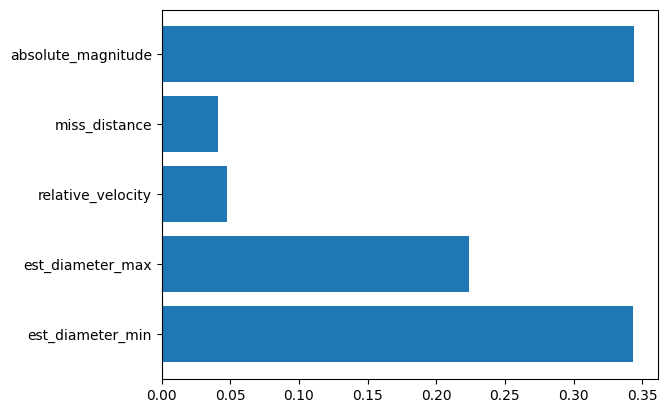

In [ ]:
plt.barh(width=tree.feature_importances_, y=X_class.columns);

Наиболее важные признаки: ```absolute_magnitude```, ```est_diametr_max```, ```est_diametr_min```

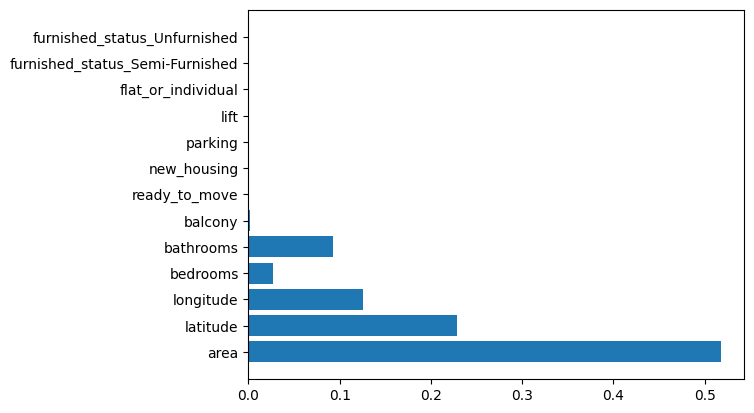

In [188]:
plt.barh(width=tree_regression.feature_importances_, y= X_reg.columns);

Наиболее важные признаки: ```bathrooms```, ```longitude```, ```latitude```, ```area```

### **Выделение признаков**
#### PCA - Метод главных компонент 

In [ ]:
from sklearn.decomposition import PCA, KernelPCA

In [17]:
pca = PCA(n_components=3)
X_pca_class = pca.fit_transform(X_scaled_class, y_class)
X_pca_class.shape

(70000, 3)

In [18]:
sum(pca.explained_variance_ratio_)

np.float64(0.9731900405670991)

Потеряли 3% информации

In [209]:
test(X_pca_class, y_class, 'class')

                 Метрики качества
accuracy_score             0.9197
precision_score            0.8990
recall_score               0.9468
f1_score                   0.9223
Матрица ошибок (Строки: Predicted, Столбцы: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   9302     1125 |
Predicted  Class 1  |    562    10011 |
-----------------------------------
Оценка кросс-валидации (f1): 0.9104358446191856


Визуализация

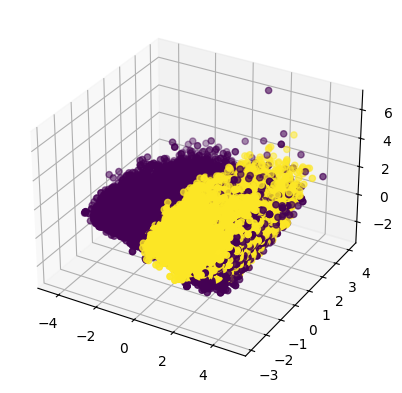

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(X_pca_class[:, 0], X_pca_class[:,1], X_pca_class[:,2], c=y_class);

In [ ]:
pca_reg = PCA(n_components=4)
X_pca_reg = pca.fit_transform(X_scaled_reg, y_reg)
sum(pca.explained_variance_ratio_)
X_pca_reg.shape

(6237, 3)

In [21]:
test(X_pca_reg, y_reg, 'reg')

               Метрики качества
MAE                     9.29656
MSE                   312.33973
RMSE                   17.67314
MAPE                    0.42679
Adjusted_rand           0.00729
R^2                     0.52176
Оценка кросс-валидации (R2): 0.5189688365692324


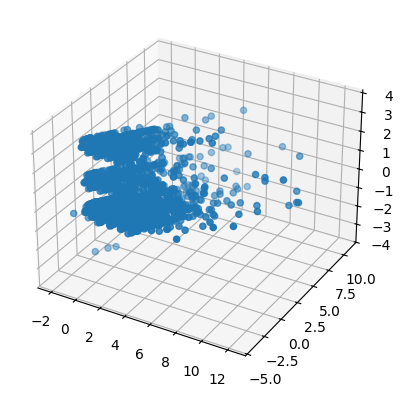

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(X_pca_reg[:, 0], X_pca_reg[:,1], X_pca_reg[:,2]);

- Качество регрессии заметно понизилось

### KernelPCA

### <span style = "color:rgb(73, 113, 162)">poly</span>

In [ ]:
pca_poly_class = KernelPCA(n_components=3, kernel='poly')

#### Нелинейные методы выделения признаков

In [24]:
from sklearn.manifold import TSNE, Isomap

In [ ]:
tsne = TSNE(n_components=2)
X_tsne_class = tsne.fit_transform(X_scaled_class)


In [41]:

test(X_tsne_class, y_class, 'class')
X_tsne_class.shape

                 Метрики качества
accuracy_score             0.9083
precision_score            0.8966
recall_score               0.9211
f1_score                   0.9087
Матрица ошибок (Строки: Predicted, Столбцы: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   9497     1105 |
Predicted  Class 1  |    820     9578 |
-----------------------------------
Оценка кросс-валидации (f1): 0.900830089584406


(70000, 2)

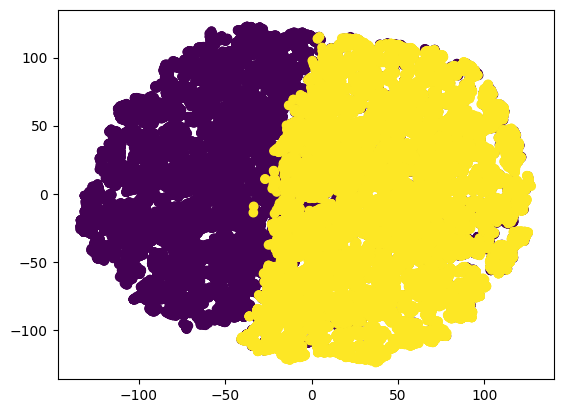

In [242]:
plt.scatter(X_tsne_class[:, 0], X_tsne_class[:,1], c=y_class);

In [ ]:
tsne = TSNE(n_components=3)
X_tsne_reg = tsne.fit_transform(X_scaled_reg)
X_tsne_reg.shape

In [28]:
test(X_tsne_reg, y_reg, 'reg')

               Метрики качества
MAE                     9.24998
MSE                   336.79119
RMSE                   18.35187
MAPE                    0.42530
Adjusted_rand           0.00235
R^2                     0.58592
Оценка кросс-валидации (R2): 0.5746681892952635


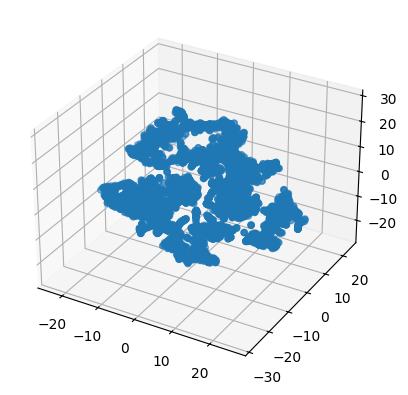

In [46]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(X_tsne_reg[:, 0], X_tsne_reg[:,1], X_tsne_reg[:,2]);

- Качество классификации для 2-x признаков осталось прежним
- Качество регрессии заметно ухудшилось

**Isomap**

In [ ]:
isomap_class = Isomap(n_components=2)
X_isomap = isomap_class.fit_transform(X_scaled_class)

In [ ]:
plt.scatter(X_isomap[:, 0], X_isomap[:,1], c=y_class);